In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import os
while 'notebooks' in os.getcwd():
    os.chdir('..')

import logging
dataset_name = 'ogbn-arxiv'
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename=f'logs/omega_function/{dataset_name}/10-1-graph_sage_node_classifier.log'
)

In [3]:
import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.data.gamma.structural_arxiv import load_dataset, get_train_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.node_classifier.graph_sage import NodeClassifierOmegaGraphSageCosSim

In [4]:
dataset_name = 'ogbn-arxiv'

In [5]:
node_evaluator = Evaluator(name='ogbn-arxiv')

In [6]:
torch.cuda.is_available()

True

In [7]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [8]:
dataset = load_dataset()

In [9]:
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device=device)

In [10]:
data = prepare_adjencency(data)

In [11]:
nodes_train = dataset.get_idx_split()['train']
nodes_val = dataset.get_idx_split()['valid']
nodes_test = dataset.get_idx_split()['test']

## Training

In [12]:
nodes_train.shape

torch.Size([90941])

In [13]:
1024 * 1024

1048576

omega.train_epoch(
    nodes_train,
    data.x,
    data.y,
    data.adj_t,
)

In [14]:
for run in range(30):
    for n_layers_graph_sage in range(1, 4):
        omega = NodeClassifierOmegaGraphSageCosSim(
            device,
            dataset="ogbn-arxiv",
            node_evaluator=node_evaluator,
            n_layers_graph_sage=n_layers_graph_sage,
            run=run,
        )
        torch.cuda.empty_cache()
        omega.train(
            edges_train,
            edges_val,
            edges_test,
            nodes_train,
            nodes_val,
            nodes_test,
            data.x,
            data.y,
            data.adj_t,
        )

KeyboardInterrupt: 

## Results

### For a Layer Number

In [40]:
n_layers_graph_sage = 2

In [41]:
metrics = NodeClassifierOmegaGraphSageCosSim.read_metrics(
    n_layers_graph_sage=n_layers_graph_sage,
    dataset='ogbn-arxiv')
print(metrics.shape)
metrics.head()

(306, 11)


,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test,nodes_acc_train,nodes_acc_val,nodes_acc_test
0,0,0,3.706363,3.677348,3.680395,0.555474,0.564737,0.561533,0.032241,0.026209,0.025636
1,0,100,1.318498,1.326226,1.395099,0.718729,0.730165,0.720238,0.632157,0.644048,0.638520
2,0,200,1.168105,1.172896,1.232841,0.721905,0.733462,0.723119,0.666971,0.668647,0.662140
3,0,300,1.105257,1.116581,1.172427,0.719729,0.730351,0.720026,0.679979,0.677707,0.670082
4,0,400,1.065038,1.084312,1.136354,0.716877,0.726328,0.716060,0.689337,0.683781,0.674773


### Sumarize metrics per epoch

In [42]:
metrics_cols = metrics.columns[2:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test', 'nodes_acc_train', 'nodes_acc_val', 'nodes_acc_test'],
      dtype='object')

In [43]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [44]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std,nodes_acc_train_mean,nodes_acc_train_std,nodes_acc_val_mean,nodes_acc_val_std,nodes_acc_test_mean,nodes_acc_test_std
epoch,,,,,,,,,,,,,,,,,,
0,3.701750,0.023551,3.680549,0.015526,3.678325,0.013752,0.552992,0.002145,0.562971,0.001927,0.560088,0.001642,0.025744,0.013736,0.017031,0.008458,0.016806,0.006722
100,1.295091,0.017508,1.304330,0.016393,1.372992,0.017154,0.717547,0.001313,0.728551,0.001831,0.718315,0.001862,0.637553,0.004091,0.646733,0.002908,0.641476,0.004182
200,1.151958,0.011652,1.159454,0.010037,1.219355,0.010153,0.720760,0.001650,0.731764,0.001762,0.721517,0.001755,0.670543,0.002704,0.671163,0.002413,0.664400,0.002537
300,1.090696,0.010559,1.106815,0.007925,1.163301,0.008590,0.719614,0.001373,0.729547,0.001714,0.719217,0.001764,0.684273,0.002709,0.679978,0.002492,0.672311,0.003167
400,1.051292,0.010494,1.077467,0.006154,1.131830,0.005858,0.717251,0.001315,0.726283,0.001788,0.715831,0.001700,0.692762,0.002504,0.684480,0.002462,0.674598,0.001884


In [45]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std,nodes_acc_train_mean,nodes_acc_train_std,nodes_acc_val_mean,nodes_acc_val_std,nodes_acc_test_mean,nodes_acc_test_std
epoch,,,,,,,,,,,,,,,,,,
200,1.151958,0.011652,1.159454,0.010037,1.219355,0.010153,0.720760,0.001650,0.731764,0.001762,0.721517,0.001755,0.670543,0.002704,0.671163,0.002413,0.664400,0.002537
300,1.090696,0.010559,1.106815,0.007925,1.163301,0.008590,0.719614,0.001373,0.729547,0.001714,0.719217,0.001764,0.684273,0.002709,0.679978,0.002492,0.672311,0.003167
100,1.295091,0.017508,1.304330,0.016393,1.372992,0.017154,0.717547,0.001313,0.728551,0.001831,0.718315,0.001862,0.637553,0.004091,0.646733,0.002908,0.641476,0.004182
400,1.051292,0.010494,1.077467,0.006154,1.131830,0.005858,0.717251,0.001315,0.726283,0.001788,0.715831,0.001700,0.692762,0.002504,0.684480,0.002462,0.674598,0.001884
500,1.022011,0.010613,1.057915,0.006826,1.110934,0.007544,0.714917,0.001070,0.722932,0.001670,0.712474,0.001629,0.698900,0.002952,0.686975,0.002741,0.676440,0.003850


In [47]:
epoch_metrics.sort_values('nodes_acc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std,nodes_acc_train_mean,nodes_acc_train_std,nodes_acc_val_mean,nodes_acc_val_std,nodes_acc_test_mean,nodes_acc_test_std
epoch,,,,,,,,,,,,,,,,,,
3200,0.842319,0.020597,1.001713,0.005240,1.053095,0.006175,0.697796,0.001547,0.699934,0.002635,0.688489,0.002597,0.741746,0.005001,0.695465,0.002246,0.681028,0.002318
2800,0.850665,0.019811,1.001096,0.005296,1.052096,0.005789,0.697895,0.001455,0.699818,0.002187,0.688309,0.002169,0.739677,0.005068,0.695443,0.002060,0.681556,0.002352
4900,0.819480,0.023575,1.006436,0.003726,1.057193,0.003070,0.698030,0.001767,0.701005,0.002848,0.689743,0.002756,0.747466,0.005883,0.695415,0.002463,0.680267,0.001576
3100,0.844516,0.020468,1.001468,0.004788,1.052671,0.006261,0.697822,0.001740,0.699919,0.002665,0.688437,0.002504,0.741133,0.004945,0.695381,0.001465,0.681299,0.002636
4300,0.826017,0.022408,1.004916,0.003600,1.055411,0.005167,0.697653,0.001897,0.700248,0.002827,0.688966,0.002753,0.745883,0.005477,0.695241,0.002214,0.680836,0.002178


/tmp/ipykernel_70482/1710618901.py:61: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_70482/1710618901.py:62: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



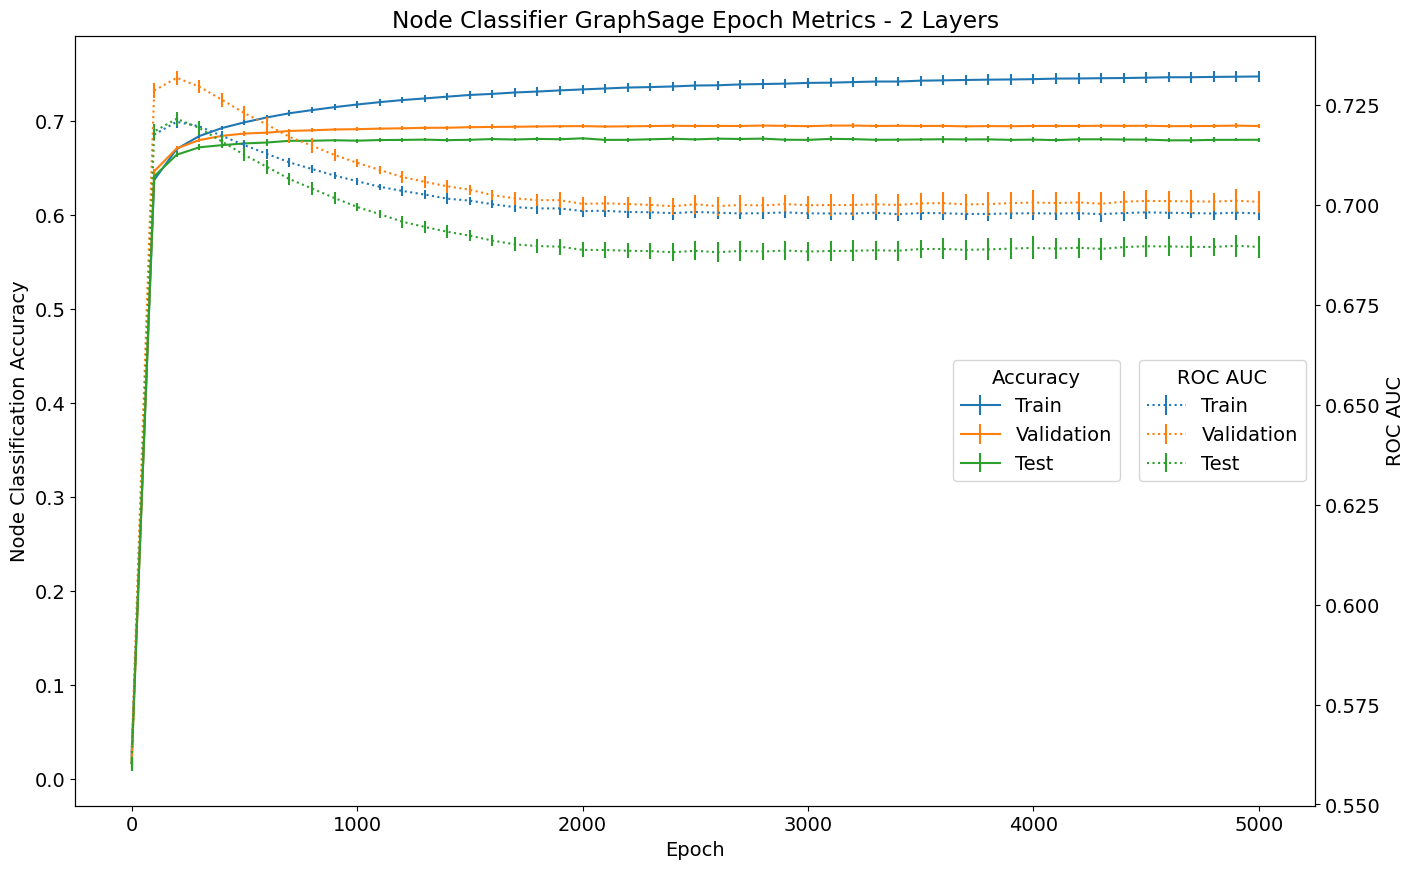

In [46]:
plt.rcParams["font.size"] = "14"
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title(
    f"Node Classifier GraphSage Epoch Metrics - {n_layers_graph_sage} Layers"
)

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics["nodes_acc_train_mean"],
    yerr=epoch_metrics["nodes_acc_train_std"],
    ls="-",
    label="Train",
)

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics["nodes_acc_val_mean"],
    yerr=epoch_metrics["nodes_acc_val_std"],
    ls="-",
    label="Validation",
)

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics["nodes_acc_test_mean"],
    yerr=epoch_metrics["nodes_acc_test_std"],
    ls="-",
    label="Test",
)

# ax1.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['loss_train_mean'][1:],
#     # yerr=epoch_metrics['loss_train_std'][1:],
#     ls='-',
#     label='Train')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_val_mean'],
#     # yerr=epoch_metrics['loss_val_std'],
#     ls='-',
#     label='Validation')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_test_mean'],
#     # yerr=epoch_metrics['loss_test_std'],
#     ls='-',
#     label='Test')

ax1.legend(loc="center right", title="Accuracy", bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel("Node Classification Accuracy")
ax1.set_xlabel("Epoch")

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics["auc_train_mean"][1:],
    yerr=epoch_metrics["auc_train_std"][1:],
    ls=":",
    label="Train",
)

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics["auc_val_mean"],
    yerr=epoch_metrics["auc_val_std"],
    ls=":",
    label="Validation",
)

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics["auc_test_mean"],
    yerr=epoch_metrics["auc_test_std"],
    ls=":",
    label="Test",
)

# ax2.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['auc_train_mean'][1:],
#     # yerr=epoch_metrics['auc_train_std'][1:],
#     ls=':',
#     label='Train')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_val_mean'],
#     # yerr=epoch_metrics['auc_val_std'],
#     ls=':',
#     label='Validation')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_test_mean'],
#     # yerr=epoch_metrics['auc_test_std'],
#     ls=':',
#     label='Test')

ax2.legend(loc="center right", title="ROC AUC", bbox_to_anchor=[1, 0.5])
ax2.set_ylabel("ROC AUC")

plt.savefig(
    f"reports/images/node_classifier_omega_graphsage_cossim_training_metrics_{n_layers_graph_sage}gslayers.pdf"
)

### Comparing Validation Performance for All Layer numbers

In [25]:
n_layers_list = range(1, 4)

In [27]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}
for n_layers_graph_sage in n_layers_list:
    metrics = NodeClassifierOmegaGraphSageCosSim.read_metrics(
        dataset=dataset_name,
        n_layers_graph_sage=n_layers_graph_sage
    )
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[n_layers_graph_sage] = auc_val
    mean_loss_val_dict[n_layers_graph_sage] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[n_layers_graph_sage] = auc_val
    std_loss_val_dict[n_layers_graph_sage] = loss_val

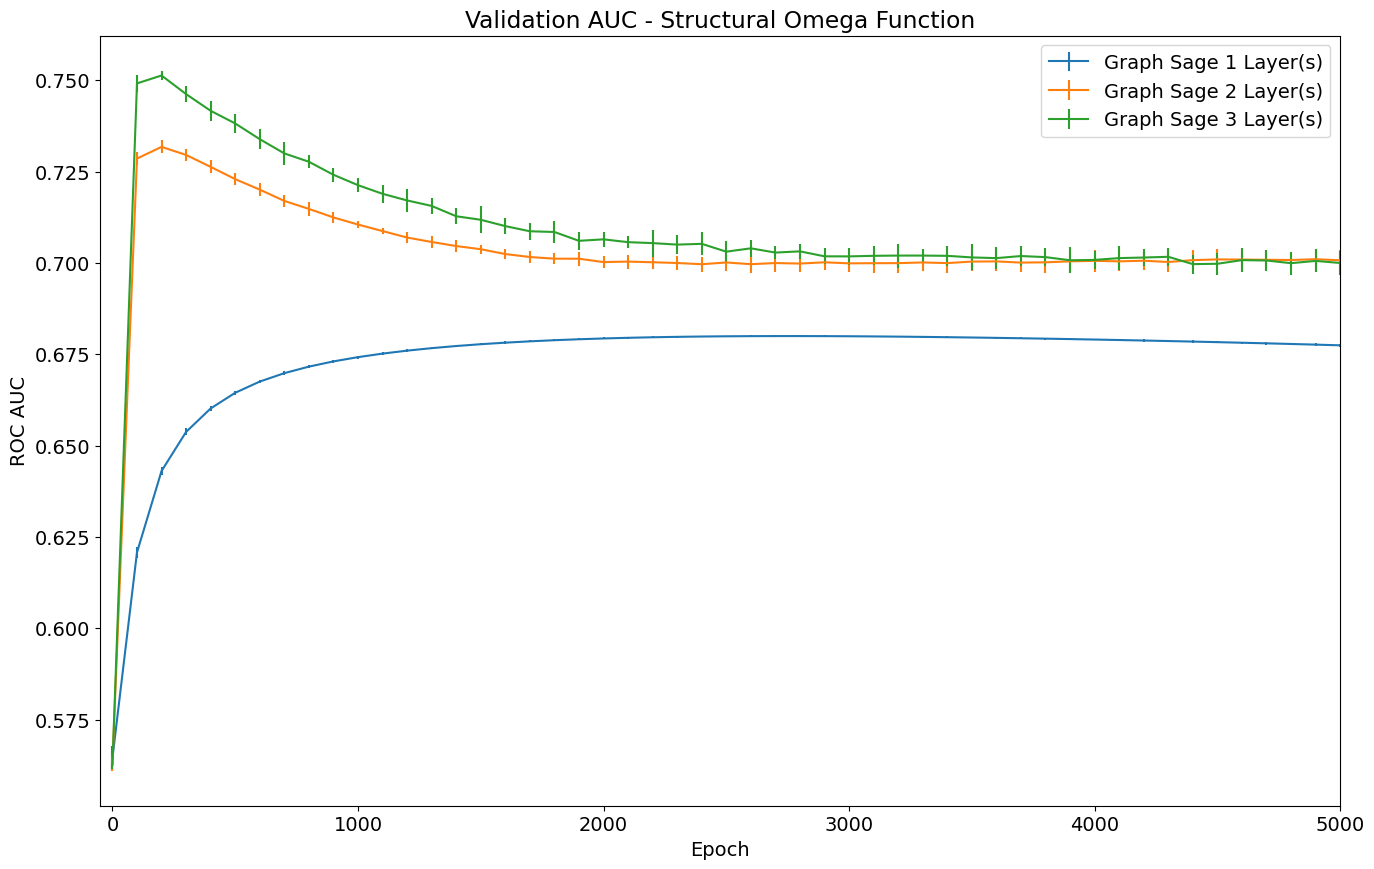

In [28]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Structural Omega Function')

for n_layers in mean_auc_val_dict:
    ax1.errorbar(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        yerr=std_auc_val_dict[n_layers],
        ls='-',
        label=f'Graph Sage {n_layers} Layer(s)')

ax1.set_xlim(-50, 5000)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC AUC')

ax1.legend()

## Comparison with structural embeddings

In [51]:
from src.train.structural_omega.graph_sage import StructuralOmegaGraphSageCosSim
from sklearn.model_selection import ParameterGrid

In [52]:
model_parameters = [
    {
        'model': StructuralOmegaGraphSageCosSim,
        'model_name': "$\Omega_{s}GraphSage$",
        'parameter_range':{
            'n_layers_graph_sage': list(range(1, 4))
        }
    },
    {
        'model': NodeClassifierOmegaGraphSageCosSim,
        'model_name': "Node Classifier",
        'parameter_range':{
            'n_layers_graph_sage': list(range(1, 4))
        }
    },
]

In [57]:
model_series_list = []

for model_dict in model_parameters:
    model = model_dict['model']
    model_name = model_dict['model_name']
    for params in ParameterGrid(model_dict['parameter_range']):
        metrics = model.read_metrics(dataset_name, **params)
        aucs_list = []
        for run in metrics['run'].unique():
            sub_df = metrics.query(f'run == {run}')
            idxmax = sub_df['auc_val'].idxmax()
            aucs = sub_df.loc[idxmax, ['auc_train', 'auc_val', 'auc_test']]
            aucs_list.append(aucs.rename(run))

        aucs_df = pd.concat(aucs_list, axis=1).rename_axis(columns='run').T
        aucs_mean = aucs_df.mean()
        aucs_std = aucs_df.std()

        model_series_list.append(pd.Series({
            'dataset': dataset_name,
            'model_name': model_name,
            'n_layers': params['n_layers_graph_sage'],
            'mean_auc_train': aucs_mean['auc_train'],
            'std_auc_train': aucs_std['auc_train'],
            'mean_auc_val': aucs_mean['auc_val'],
            'std_auc_val': aucs_std['auc_val'],
            'mean_auc_test': aucs_mean['auc_test'],
            'std_auc_test': aucs_std['auc_test'],
        }))

summary_df = pd.concat(model_series_list, axis=1).T

In [58]:
summary_df

,dataset,model_name,n_layers,mean_auc_train,std_auc_train,mean_auc_val,std_auc_val,mean_auc_test,std_auc_test
0,ogbn-arxiv,Structural Omega,1,0.833655,0.000578,0.803573,0.000166,0.774845,0.000308
1,ogbn-arxiv,Structural Omega,2,0.876891,0.005401,0.82857,0.001862,0.79265,0.002747
2,ogbn-arxiv,Structural Omega,3,0.890174,0.002311,0.848632,0.001677,0.817013,0.001488
3,ogbn-arxiv,Node Classifier,1,0.672721,0.025492,0.671675,0.021974,0.660716,0.02155
4,ogbn-arxiv,Node Classifier,2,0.72076,0.00165,0.731764,0.001762,0.721517,0.001755
5,ogbn-arxiv,Node Classifier,3,0.732528,0.001456,0.751298,0.001304,0.740404,0.001063


In [ ]:
summary_df['mean_auc_val'].astype(float).idxmax()

91

In [ ]:
def get_max(model_df):
    idxmax = model_df['mean_auc_val'].astype(float).idxmax()
    return model_df.loc[idxmax].drop(index=['dataset', 'model_name', 'params']).astype(float)


best_df = summary_df.groupby(['dataset', 'model_name'], group_keys=False).apply(
    get_max)

best_df.style.background_gradient(axis=0).format(lambda x: f'{x:.3f}')


In [ ]:
print(best_df.style.format(lambda x: f'{x:.3f}').to_latex())

\begin{tabular}{llrrrrrr}
 &  & mean_auc_train & std_auc_train & mean_auc_val & std_auc_val & mean_auc_test & std_auc_test \\
dataset & model_name &  &  &  &  &  &  \\
\multirow[c]{6}{*}{citeseer} & $\Omega_{p}GraphSage$ & 0.582 & 0.017 & 0.627 & 0.013 & 0.583 & 0.013 \\
 & $\Omega_{p}Node2Vec$ & 0.477 & 0.031 & 0.535 & 0.017 & 0.483 & 0.011 \\
 & $\Omega_{s}GAT$ & 0.924 & 0.030 & 0.697 & 0.010 & 0.631 & 0.018 \\
 & $\Omega_{s}GCN$ & 0.917 & 0.003 & 0.708 & 0.002 & 0.683 & 0.002 \\
 & $\Omega_{s}GraphSage$ & 1.000 & 0.000 & 0.786 & 0.002 & 0.751 & 0.005 \\
 & $\Omega_{s}MLP$ & 0.989 & 0.006 & 0.676 & 0.002 & 0.663 & 0.005 \\
\multirow[c]{6}{*}{cora} & $\Omega_{p}GraphSage$ & 0.713 & 0.008 & 0.791 & 0.005 & 0.730 & 0.005 \\
 & $\Omega_{p}Node2Vec$ & 0.617 & 0.011 & 0.635 & 0.012 & 0.596 & 0.011 \\
 & $\Omega_{s}GAT$ & 0.945 & 0.009 & 0.853 & 0.012 & 0.789 & 0.015 \\
 & $\Omega_{s}GCN$ & 0.995 & 0.000 & 0.878 & 0.002 & 0.819 & 0.002 \\
 & $\Omega_{s}GraphSage$ & 1.000 & 0.000 & 0.871 & 0

In [ ]:
model_parameters = [
    {
        'model': StructuralOmegaMLP,
        'model_name': "$\Omega_{s}MLP$",
        'parameter_range':{
            'n_layers': list(range(1, 6))
        }
    },
    {
        'model': StructuralOmegaGraphSageCosSim,
        'model_name': "$\Omega_{s}GraphSage$",
        'parameter_range':{
            'n_layers_graph_sage': list(range(1, 4))
        }
    },
    {
        'model': StructuralOmegaGCNCosSim,
        'model_name': "$\Omega_{s}GCN$",
        'parameter_range':{
            'n_layers_gcn': list(range(1, 4))
        }
    },
    {
        'model': StructuralOmegaGATCosSim,
        'model_name': "$\Omega_{s}GAT$",
        'parameter_range':{
            'n_layers_gat': list(range(1, 4))
        }
    },
    {
        'model': PositionalOmegaGraphSageCosSim,
        'model_name': "$\Omega_{p}GraphSage$",
        'parameter_range':{
            'n_layers': list(range(1, 4))
        }
    },
    {
        'model': PositionalOmegaNode2Vec,
        'model_name': "$\Omega_{p}Node2Vec$",
        'parameter_range':{
            'p': np.logspace(-1, 1, 5).round(2).tolist(),
            'q': np.logspace(-1, 1, 5).round(2).tolist()
        }
    }
]
model_series_list = []
for dataset in ['ogbn-arxiv', 'cora', 'pubmed', 'citeseer']:
    for model_dict in model_parameters:
        model = model_dict['model']
        model_name = model_dict['model_name']
        for params in ParameterGrid(model_dict['parameter_range']):
            metrics = model.read_metrics(dataset, **params)
            aucs_list = []
            for run in metrics['run'].unique():
                sub_df = metrics.query(f'run == {run}')
                idxmax = sub_df['auc_val'].idxmax()
                aucs = sub_df.loc[idxmax, ['auc_train', 'auc_val', 'auc_test']]
                aucs_list.append(aucs.rename(run))

            aucs_df = pd.concat(aucs_list, axis=1).rename_axis(columns='run').T
            aucs_mean = aucs_df.mean()
            aucs_std = aucs_df.std()

            model_series_list.append(pd.Series({
                'dataset': dataset,
                'model_name': model_name,
                'params': params,
                'mean_auc_train': aucs_mean['auc_train'],
                'std_auc_train': aucs_std['auc_train'],
                'mean_auc_val': aucs_mean['auc_val'],
                'std_auc_val': aucs_std['auc_val'],
                'mean_auc_test': aucs_mean['auc_test'],
                'std_auc_test': aucs_std['auc_test'],
            }))

summary_df = pd.concat(model_series_list, axis=1).T
summary_df['mean_auc_val'].astype(float).idxmax()
def get_max(model_df):
    idxmax = model_df['mean_auc_val'].astype(float).idxmax()
    return model_df.loc[idxmax].drop(index=['dataset', 'model_name', 'params']).astype(float)


best_df = summary_df.groupby(['dataset', 'model_name'], group_keys=False).apply(
    get_max)

best_df.style.background_gradient(axis=0).format(lambda x: f'{x:.3f}')

print(best_df.style.format(lambda x: f'{x:.3f}').to_latex())

## Score Best model

In [32]:
best_model_metrics = metrics.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

run                  5.000000
epoch              200.000000
loss_train           1.039836
loss_val             1.068710
loss_test            1.126992
auc_train            0.732805
auc_val              0.752225
auc_test             0.741287
nodes_acc_train      0.700421
nodes_acc_val        0.694017
nodes_acc_test       0.683373
Name: 257, dtype: float64

In [36]:
os.listdir(f'models/node_classifier_graph_sage_cossim')

['ogbn-arxiv']

In [28]:
best_model_metrics.to_json(f'models/node_classifier_graph_sage_cossim/{dataset_name}/best_model_info.json')

### Load data

In [30]:
dataset = load_dataset()

data, edges_train, edges_val, edges_test = get_train_val_test_edges(
    dataset=dataset, device=device
)

data = prepare_adjencency(data, to_symmetric=True)

edge_index = get_edge_index_from_adjencency(data, device)

### Load model

In [31]:
data.num_nodes

169343

In [36]:
omega = StructuralOmegaGraphSageCosSim.load_model(
    dataset=dataset_name,
    run=int(best_model_metrics['run']),
    epoch=int(best_model_metrics['epoch']),
    device=device,
    n_layers_graph_sage=3,
    batch_size=1024)

In [37]:
dataset

PygNodePropPredDataset()

### Score model

In [38]:
dataset = load_dataset()
data = prepare_adjencency(dataset[0], to_symmetric=True).to(device)

edge_index = get_edge_index_from_adjencency(data, device)

In [39]:
edge_index

tensor([[   411,    640,   1162,  ..., 163274,  27824, 158981],
        [     0,      0,      0,  ..., 169341, 169342, 169342]],
       device='cuda:0')

In [40]:
edges_train

tensor([[104447,  15858, 107156,  ...,   1326, 129609,  26457],
        [ 13091,  47283,  69161,  ...,  55379, 158430,  54167]],
       device='cuda:0')

In [42]:
preds_train = omega.forward(edges_train, data.x, data.adj_t).to('cpu').detach().numpy()
preds_train[:5]

array([[0.39369652],
       [0.11731733],
       [0.46927968],
       [0.12220458],
       [0.04423578]], dtype=float32)

In [43]:
preds_val = omega.forward(edges_val, data.x, data.adj_t).to('cpu').detach().numpy()
preds_val[:5]

array([[0.9460168 ],
       [0.83816004],
       [0.8740781 ],
       [0.35600442],
       [0.6821827 ]], dtype=float32)

In [44]:
preds_test = omega.forward(edges_test, data.x, data.adj_t).to('cpu').detach().numpy()
preds_test[:5]

array([[0.889694  ],
       [0.73500896],
       [0.834004  ],
       [0.58543926],
       [0.7033087 ]], dtype=float32)

In [45]:
preds = np.concatenate([preds_train, preds_val, preds_test])

In [46]:
edges = torch.concat([edges_train, edges_val, edges_test], dim=1)
edges

tensor([[104447,  15858, 107156,  ...,  45118,  45118,  45118],
        [ 13091,  47283,  69161,  ..., 162473, 162537,  72717]],
       device='cuda:0')

In [47]:
theta = omega.is_same_class(edges, data.y).to('cpu').detach().numpy()

In [48]:
roc_auc_score(theta, preds)

0.8699908991623656

In [49]:
theta.mean()

0.655083031580897

### Save output

In [50]:
cpu_edges = edges.to('cpu').numpy()
edges_omega_df = pd.DataFrame({
    'source': cpu_edges[0],
    'target': cpu_edges[1],
    'omega_pred': preds[:,0]
})
print(edges_omega_df.shape)
edges_omega_df.head()

(1166243, 3)


,source,target,omega_pred
0,104447,13091,0.393697
1,15858,47283,0.117317
2,107156,69161,0.469280
3,107156,136440,0.122205
4,107156,107366,0.044236


In [51]:
edges_omega_df.to_csv(f'data/scored_omega/{dataset_name}/structural_omega_graph_sage_cossim.csv', index=False)

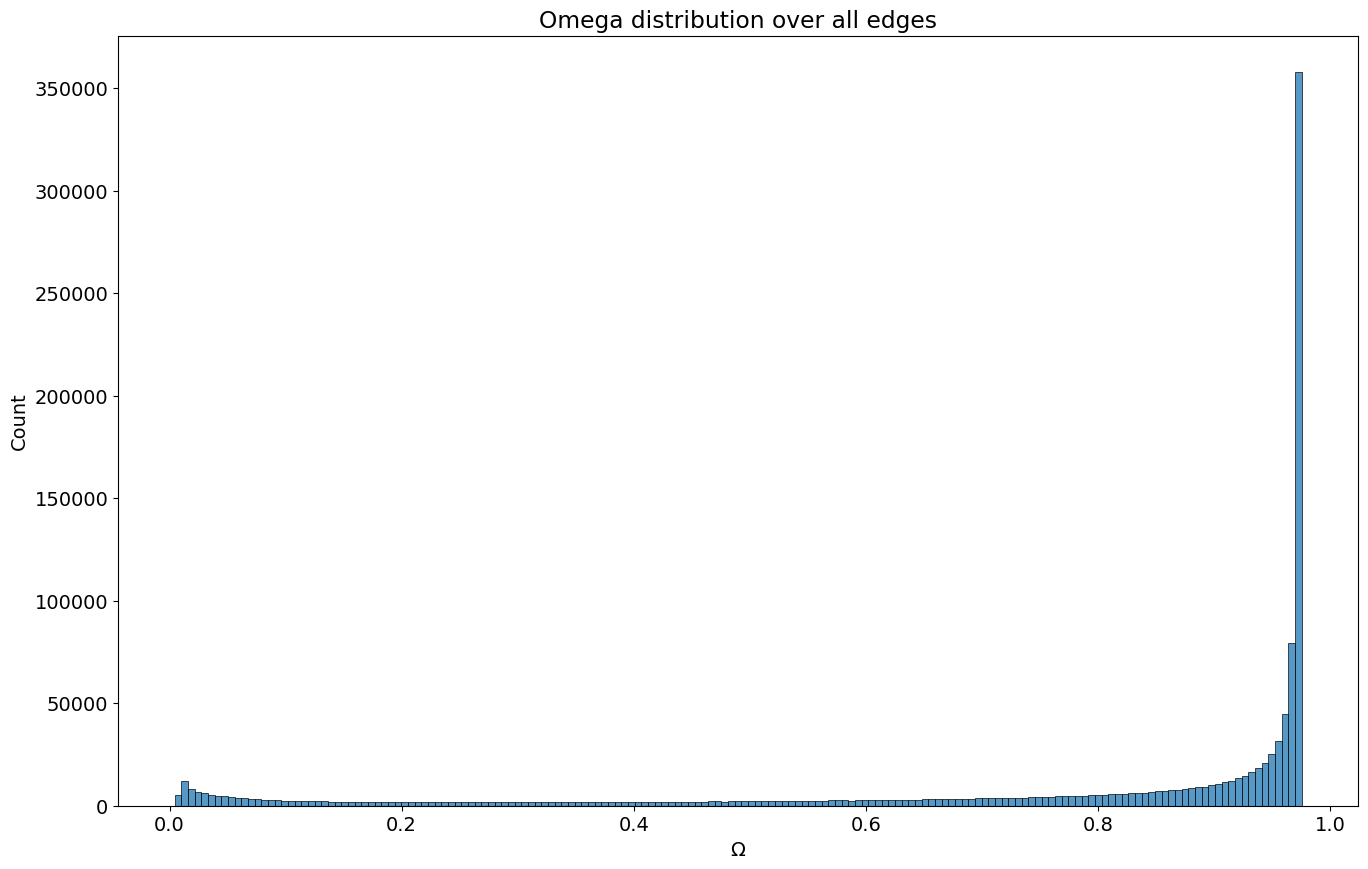

In [53]:
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(16, 10))

sns.histplot(
    edges_omega_df['omega_pred'])

plt.xlabel('$\Omega$')
plt.title('Omega distribution over all edges')
plt.savefig(f'reports/images/{dataset_name}/structural_omega_graph_sage_cossim/best_omega_distribution.png')

In [54]:
metrics = {
    'ROC AUC - All edges': [roc_auc_score(theta, preds)],
    'Mean': [edges_omega_df['omega_pred'].mean()],
    'Std. Dev.': [edges_omega_df['omega_pred'].std()],
    'Skewness': [edges_omega_df['omega_pred'].skew()],
    'Kurtosis': [edges_omega_df['omega_pred'].kurt()],
}

print(pd.DataFrame(metrics).round(3).style.to_latex())

\begin{tabular}{lrrrrr}
 & ROC AUC - All edges & Mean & Std. Dev. & Skewness & Kurtosis \\
0 & 0.870000 & 0.769000 & 0.297000 & -1.420000 & 0.642000 \\
\end{tabular}

